# Introduction
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become cancer, with melanoma being the deadliest skin cancer. Its incidence has increased during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for skin cancer detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).

## Goal of the challenge
The goal of this challenge is to classify dermoscopic images of skin lesions among eight different diagnostic classes:
1. Melanoma
2. Melanocytic nevus
3. Basal cell carcinoma
4. Actinic keratosis
5. Benign keratosis
6. Dermatofibroma
7. Vascular lesion
8. Squamous cell carcinoma
In order to do that, you will extract features such as the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (usually called the ABCD rule). After that, you will use machine learning algorithms to classify the images.

# Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from skimage.io import imread
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

#from tensorflow.keras.models import Sequential

In [2]:
train_directory = './Train/Train'
test_directory = './Test/Test'

# Data
You will use a data-set of 25331 dermoscopic images of skin lesions with, when available, their relative segmentation and metadata (age, sex and anatomical position). Data has already been randomly split into a training-validation set (75%) and a test set (25%). You only have the classification (made by clinicians) of the training-validation set. The goal of the project is to estimate the correct class of each dermoscopic image in the test set. **You can only use the data provided in this challenge**



### Data Load

In [3]:
# Load the data
train_data = pd.read_csv('metadataTrain.csv')
test_data = pd.read_csv('metadataTest.csv')


In [79]:
# Load the images
train_images_filenames = os.listdir(train_directory)
test_images_filenames = os.listdir(test_directory)

train_images = []
train_masks = []
test_images = []
test_masks = []

print(len(train_images_filenames))
print(train_images_filenames)


#Give me the code to put the images in the lists, the masks in the other lists, the mask are the images that finish with _seg.png
for image in train_images_filenames:
    if image.endswith('_seg.png'):
        #Save the name whitout the _seg.png and the image
        train_masks.append([image[:-8], imread(train_directory + '/' + image)])
    else:
        #Save the name without the .png and the image
        train_images.append([image[:-4], imread(train_directory + '/' + image)])
        
for image in test_images_filenames:
    if image.endswith('_seg.png'):
        #Save the name whitout the _seg.png and the image
        test_masks.append([image[:-8], imread(test_directory + '/' + image)])
    else:
        #Save the name without the .png and the image
        test_images.append([image[:-4], imread(test_directory + '/' + image)])



20943
['ISIC_0000000.jpg', 'ISIC_0000000_seg.png', 'ISIC_0000001.jpg', 'ISIC_0000001_seg.png', 'ISIC_0000002.jpg', 'ISIC_0000003.jpg', 'ISIC_0000003_seg.png', 'ISIC_0000004.jpg', 'ISIC_0000004_seg.png', 'ISIC_0000007.jpg', 'ISIC_0000007_seg.png', 'ISIC_0000008.jpg', 'ISIC_0000008_seg.png', 'ISIC_0000009.jpg', 'ISIC_0000009_seg.png', 'ISIC_0000010.jpg', 'ISIC_0000012.jpg', 'ISIC_0000012_seg.png', 'ISIC_0000013.jpg', 'ISIC_0000013_seg.png', 'ISIC_0000015.jpg', 'ISIC_0000015_seg.png', 'ISIC_0000016.jpg', 'ISIC_0000016_seg.png', 'ISIC_0000017.jpg', 'ISIC_0000017_seg.png', 'ISIC_0000019.jpg', 'ISIC_0000019_seg.png', 'ISIC_0000020.jpg', 'ISIC_0000020_seg.png', 'ISIC_0000021.jpg', 'ISIC_0000021_seg.png', 'ISIC_0000023.jpg', 'ISIC_0000023_seg.png', 'ISIC_0000025.jpg', 'ISIC_0000025_seg.png', 'ISIC_0000026.jpg', 'ISIC_0000026_seg.png', 'ISIC_0000027.jpg', 'ISIC_0000027_seg.png', 'ISIC_0000028.jpg', 'ISIC_0000028_seg.png', 'ISIC_0000029.jpg', 'ISIC_0000029_seg.png', 'ISIC_0000030.jpg', 'ISIC_000

## Data Analysis

### Text Features

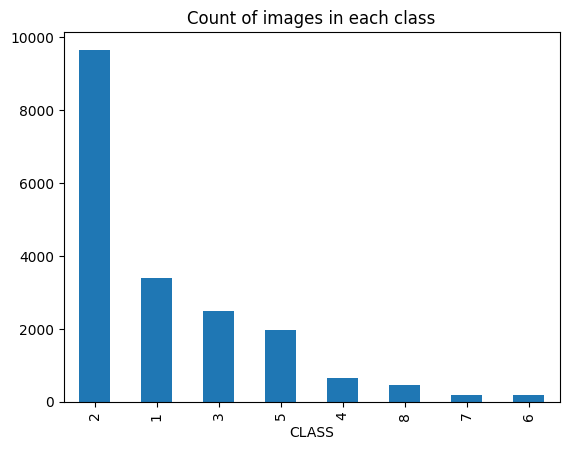

In [43]:
# Value counts of the classes
train_data['CLASS'].value_counts().plot(kind='bar')
plt.title('Count of images in each class')
plt.show()

In [68]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18998 entries, 0 to 18997
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        18998 non-null  object 
 1   CLASS     18998 non-null  int64  
 2   SEX       18714 non-null  object 
 3   AGE       18674 non-null  float64
 4   POSITION  17028 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 742.2+ KB


In [50]:
# Description of the data 
train_data.describe(include='object')

,ID,SEX,POSITION
count,18998,18714,17028
unique,18998,2,8
top,ISIC_0028766,male,anterior torso
freq,1,9978,5194


In [51]:
train_data.describe()

,CLASS,AGE
count,18998.000000,18674.000000
mean,2.568323,53.991914
std,1.532728,18.094209
min,1.000000,0.000000
25%,2.000000,40.000000
50%,2.000000,55.000000
75%,3.000000,70.000000
max,8.000000,85.000000


In [52]:
test_data.describe(include='object')

,ID,SEX,POSITION
count,6333,6233,5672
unique,6333,2,8
top,ISIC_0055289,male,anterior torso
freq,1,3308,1721


In [53]:
test_data.describe()

,AGE
count,6220.000000
mean,54.138264
std,18.241916
min,0.000000
25%,40.000000
50%,55.000000
75%,70.000000
max,85.000000


### Image Features

In [80]:
#Count images loaded
print(f'Number of training images: {len(train_images)}')
print(f'Number of training masks: {len(train_masks)}')

print(f'Number of testing images: {len(test_images)}')
print(f'Number of testing masks: {len(test_masks)}')
    

Number of training images: 18998
Number of training masks: 1945
Number of testing images: 6333
Number of testing masks: 648


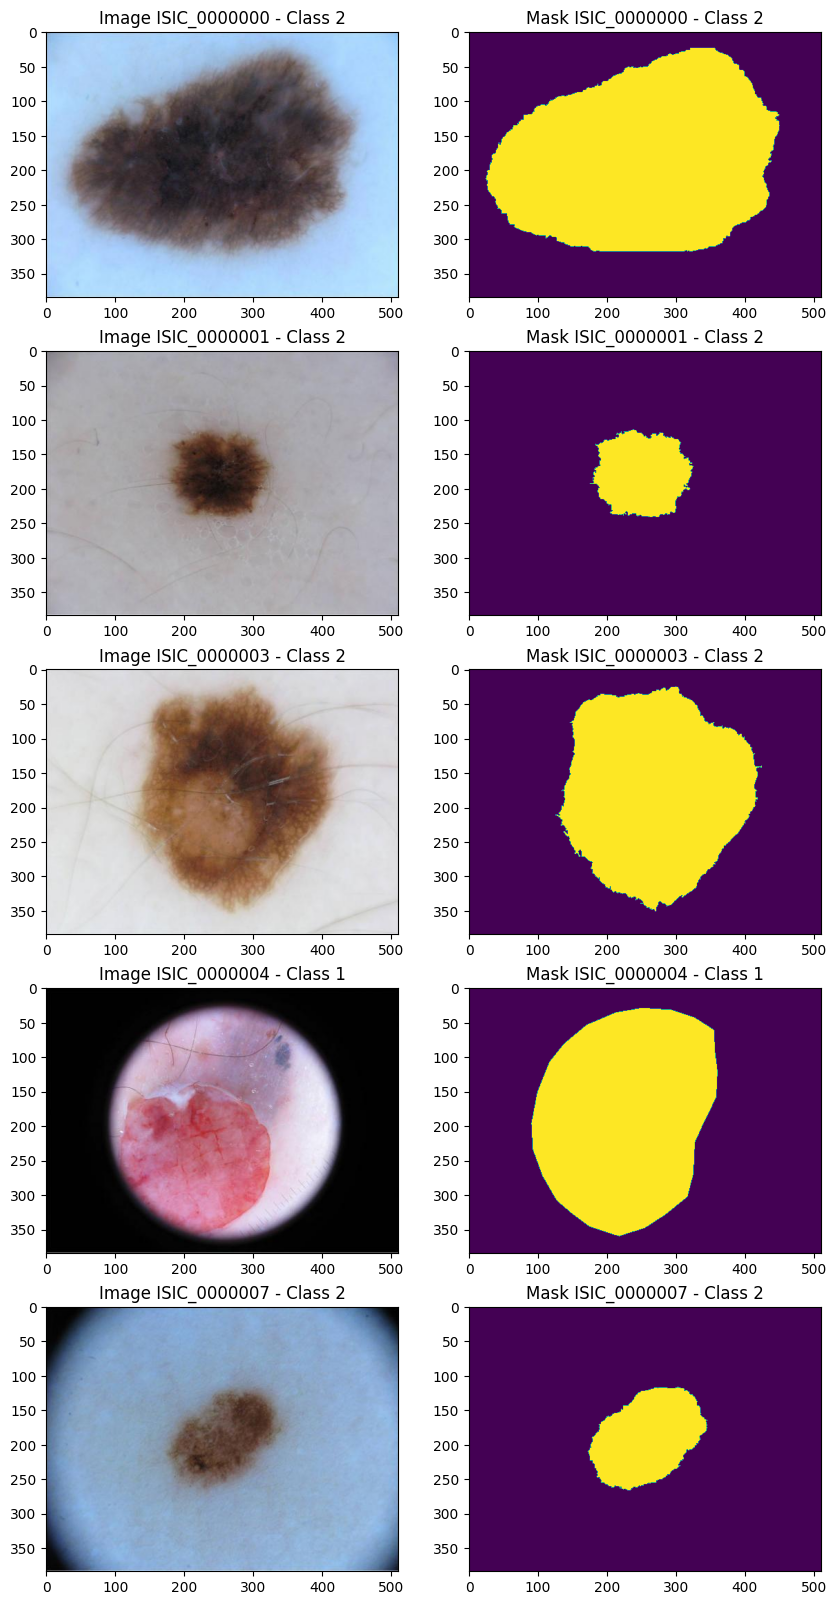

In [95]:
# Display a few images with the corresponding masks the corresponding masks have the same id as the image and their class

# Display the first 5 images
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

#get the first 5 masks
first_5_masks = [mask[0] for mask in train_masks[:5]]

j = 0
for i in first_5_masks:
    #Get the image
    image = next((item for item in train_images if item[0] == i), None)
    #Get the mask
    mask = next((item for item in train_masks if item[0] == i), None)
    
    #Get the class
    class_ = train_data[train_data['ID'] == i]['CLASS'].values[0]
    
    #Plot the image
    ax[j, 0].imshow(image[1])
    ax[j, 0].set_title(f'Image { image[0] } - Class {class_}')
    
    #Plot the mask
    ax[j, 1].imshow(mask[1])
    ax[j, 1].set_title(f'Mask {mask[0]} - Class {class_}')

    j += 1


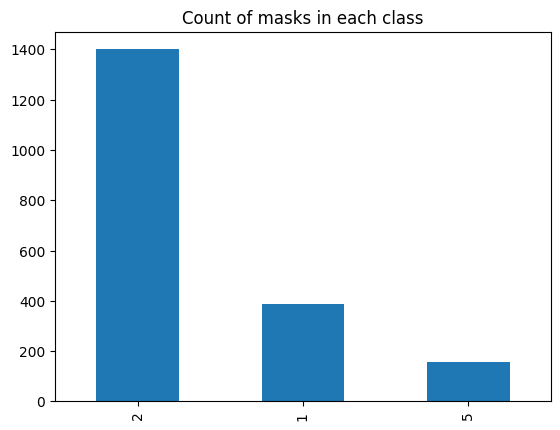

In [96]:
# Value counts of the classes in the masks

#Get the classes of the masks
masks_classes = [train_data[train_data['ID'] == mask[0]]['CLASS'].values[0] for mask in train_masks]

#Plot the classes
pd.Series(masks_classes).value_counts().plot(kind='bar')
plt.title('Count of masks in each class')
plt.show()


# Feature extraction
You can use all features you'd like. A list of references describing very well-known features can be found at the end of this page but you can find many more articles in the Literature. You can use Pubmed, Google Scholar or simply Google to look for them. By using the network of Télécom Paris or its VPN , you will have automatically access to most of the scientific journals. If you have any trouble, do not hesitate to contact me, pietro.gori@telecom-paris.fr.


## Segmentation

# Classification

# Metrics
As ranking metric, we will use the Weighted Categorization Accuracy which is defined as:
$$WA=1N∑i=1NwiI(yi=fi)$$
such that
$$∑i=1Nwi=N$$
in order to keep the maximum value equal to 1

where $y_i$ are ground truths, $f_i$ are the predicted results, and $w_i$ are the weights of the $i-th$ test image. If we make the hypothesis that we have $K$ groups - or classes - called $G={G_1,…,G_K}$ and we associate the same weight $w_t$ to all images of the same group $t$, we obtain that the weights are equal to: $w_t = \frac{ N }{ k |G_t|}$

In this way, we can take into account the imbalance nature of the data-set, if present.
Please note that the class weights in the test set are equal to: [ 0.7005531 0.24592265 0.95261733 3.64804147 1.20674543 13.19375 12.56547619 5.04219745]

# Conclusions

# References


* http://ieeexplore.ieee.org/document/918473/
* https://www.sciencedirect.com/science/article/pii/S0933365712001108#bib0180
* https://www.sciencedirect.com/science/article/pii/S0957417416302354#bib0023
* https://www.sciencedirect.com/science/article/pii/S0933365713001589
* https://www.nature.com/articles/nature21056
* https://hal-univ-bourgogne.archives-ouvertes.fr/hal-01250955/document
* https://workshop2021.isic-archive.com/
* https://workshop2020.isic-archive.com/#paper